In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [170]:
import tqdm

SEED = 42

# Update data

In [89]:
from ucimlrepo import fetch_ucirepo

# fetch dataset 
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes) 
X = adult.data.features

data = X["age"].to_numpy()

## Defines coins and intervals

In [90]:
import numpy as np

# age from 0 to 100
B_max = 100
B = np.arange(0, B_max + 1)
intervals = np.array([B[:-1], B[1:]]).T

## Plot age data

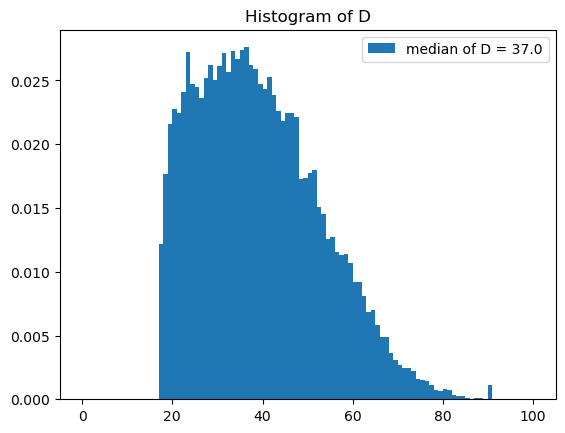

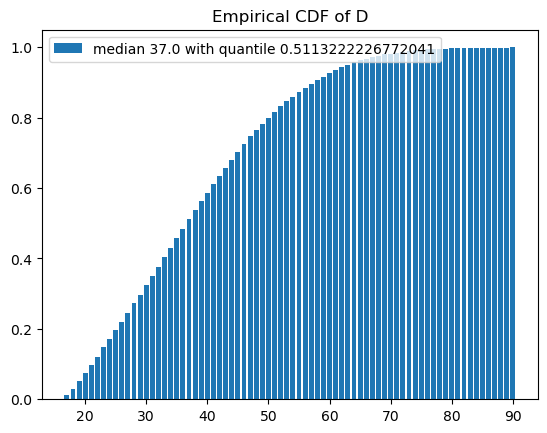

In [91]:
from scipy.stats import ecdf
import matplotlib.pyplot as plt

# plot histogram of D
plt.hist(data, bins=B, label=f"median of D = {np.median(data)}", density=True)
plt.title('Histogram of D')
plt.legend()
plt.show()

# plot ecdf of D
cf = ecdf(data)
cf_dict = dict(zip(cf.cdf.quantiles, cf.cdf.probabilities))
median = cf.cdf.quantiles[cf.cdf.probabilities >= 0.5][0]
# plot the empirical cumulative distribution function of D
plt.bar(cf.cdf.quantiles, cf.cdf.probabilities, label=f'median {median} with quantile {cf_dict[median]}')
plt.title('Empirical CDF of D')
plt.legend()
plt.show()

# Noisy Binary Search

## Fixed N, B, and success probability, find the smallest error for every epsilon

In [191]:
alpha_list = np.linspace(0.3, 0.0001, 500)
alpha_list

array([3.00000000e-01, 2.99398998e-01, 2.98797996e-01, 2.98196994e-01,
       2.97595992e-01, 2.96994990e-01, 2.96393988e-01, 2.95792986e-01,
       2.95191984e-01, 2.94590982e-01, 2.93989980e-01, 2.93388978e-01,
       2.92787976e-01, 2.92186974e-01, 2.91585972e-01, 2.90984970e-01,
       2.90383968e-01, 2.89782966e-01, 2.89181964e-01, 2.88580962e-01,
       2.87979960e-01, 2.87378958e-01, 2.86777956e-01, 2.86176954e-01,
       2.85575952e-01, 2.84974950e-01, 2.84373948e-01, 2.83772946e-01,
       2.83171944e-01, 2.82570942e-01, 2.81969940e-01, 2.81368938e-01,
       2.80767936e-01, 2.80166934e-01, 2.79565932e-01, 2.78964930e-01,
       2.78363928e-01, 2.77762926e-01, 2.77161924e-01, 2.76560922e-01,
       2.75959920e-01, 2.75358918e-01, 2.74757916e-01, 2.74156914e-01,
       2.73555912e-01, 2.72954910e-01, 2.72353908e-01, 2.71752906e-01,
       2.71151904e-01, 2.70550902e-01, 2.69949900e-01, 2.69348898e-01,
       2.68747896e-01, 2.68146894e-01, 2.67545892e-01, 2.66944890e-01,
      

In [241]:
eps_list = [0.1, 0.5, 1]
success_prob = 0.85
num_experiments = 20
alpha_list = np.linspace(0.4, 0.0001, 500)

In [242]:
from scipy.stats import bootstrap


def get_error(data, alpha=0.9, seed=0):
    confidence_interval = []
    mean = np.mean(data)
    if np.std(data) > 0:
        res = bootstrap((data,), np.mean, confidence_level=alpha, random_state=seed)
        confidence_interval.append(res.confidence_interval)
    else:
        confidence_interval.append((mean, mean))
    error = np.array(confidence_interval).flatten()
    return error

In [244]:
from noisy_binary_search.mechanism import noisy_binary_search
from DP_GPNBS.median_selection import median_bayesian_screening_search

mechanism = median_bayesian_screening_search
# mechanism = noisy_binary_search

# Hyperparameters
M = len(data)//3
replacement = False
alpha_intervals = []
start = 0
for eps in tqdm.tqdm(eps_list):
    success = np.zeros(num_experiments)
    flag_low_error = True
    for a, alpha in tqdm.tqdm(enumerate(alpha_list[start:])):
        for i in range(num_experiments):
            D = list(data)
            output = mechanism(D=D, intervals=intervals, alpha=alpha, eps=eps, M=M, replacement=replacement)
            # check if output is correct
            if output in cf_dict.keys():
                quantile_output = cf_dict[output]
            else:
                # find the higher value in the dictionary smaller than output
                if output >= min(cf_dict.keys()):
                    quantile_output = cf_dict[max([x for x in cf_dict.keys() if x <= output])]
                else:
                    quantile_output = 0
            if 0.5 - alpha < quantile_output < 0.5 + alpha:
                success[i] = 1
            else:
                success[i] = 0
        low_error, high_error = get_error(success, 0.85)
        if low_error < success_prob and flag_low_error:
            flag_low_error = False
            print(f'eps {eps} right interval alpha {alpha}')
            right_alpha = alpha
            start = a + 10
        if high_error < success_prob:
            print(f'eps {eps} left interval alpha {alpha}')
            left_alpha = alpha
            alpha_intervals.append((left_alpha, right_alpha))
            break



  0%|          | 0/3 [00:00<?, ?it/s]
0it [00:01, ?it/s]
 33%|███▎      | 1/3 [00:01<00:03,  1.71s/it]

eps 0.1 right interval alpha 0.4
eps 0.1 left interval alpha 0.4



0it [00:00, ?it/s]
1it [00:01,  1.66s/it]

eps 0.5 right interval alpha 0.3919859719438878



2it [00:03,  1.66s/it]
3it [00:04,  1.66s/it]
4it [00:06,  1.66s/it]
5it [00:08,  1.79s/it]
 33%|███▎      | 1/3 [00:10<00:21, 10.66s/it]


KeyboardInterrupt: 

In [171]:
alpha_intervals

[(0.2973636363636364, 0.3023030303030303),
 (0.030636363636363628, 0.040515151515151504),
 (0.015818181818181787, 0.020757575757575752)]

In [148]:
from noisy_binary_search.mechanism import noisy_binary_search
from DP_GPNBS.median_selection import median_bayesian_screening_search

# mechanism = median_bayesian_screening_search
mechanism = noisy_binary_search

# Hyperparameters
M = len(data)
replacement = False
max_alpha_noisy = np.zeros(len(eps_list))
for k, eps in tqdm.tqdm(enumerate(eps_list)):
    success = np.zeros(num_experiments)
    for a, alpha in tqdm.tqdm(enumerate(alpha_list)):
        for i in range(num_experiments):
            D = list(data)
            output = mechanism(D=D, intervals=intervals, alpha=alpha, eps=eps, M=M, replacement=replacement)
            # check if output is correct
            if output in cf_dict.keys():
                quantile_output = cf_dict[output]
            else:
                # find the higher value in the dictionary smaller than output
                if output >= min(cf_dict.keys()):
                    quantile_output = cf_dict[max([x for x in cf_dict.keys() if x <= output])]
                else:
                    quantile_output = 0
            if 0.5 - alpha < quantile_output < 0.5 + alpha:
                success[i] = 1
            else:
                success[i] = 0
        low_error = get_low_error(success, 0.85)
        # print(low_error)
        if low_error > success_prob:
            print(f'eps {eps} max alpha {alpha}')
            max_alpha_noisy[k] = alpha
            break

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  2.23it/s]
2it [00:00,  2.16it/s]
3it [00:01,  2.25it/s]
4it [00:01,  2.28it/s]
5it [00:02,  2.30it/s]
6it [00:02,  2.32it/s]
7it [00:03,  2.32it/s]
8it [00:03,  2.33it/s]
9it [00:03,  2.34it/s]
10it [00:04,  2.34it/s]
11it [00:04,  2.34it/s]
12it [00:05,  2.33it/s]
13it [00:05,  2.33it/s]
14it [00:06,  2.33it/s]
15it [00:06,  2.34it/s]
16it [00:06,  2.34it/s]
17it [00:07,  2.34it/s]
18it [00:07,  2.35it/s]
19it [00:08,  2.35it/s]
20it [00:08,  2.34it/s]
21it [00:09,  2.34it/s]
22it [00:09,  2.34it/s]
23it [00:09,  2.35it/s]
24it [00:10,  2.35it/s]
25it [00:10,  2.35it/s]
26it [00:11,  2.36it/s]
27it [00:11,  2.35it/s]
28it [00:12,  2.36it/s]
29it [00:12,  2.35it/s]
30it [00:12,  2.35it/s]
31it [00:13,  2.26it/s]
1it [00:13, 13.71s/it]

eps 0.1 max alpha 0.15344121212121212



0it [00:00, ?it/s]
1it [00:00,  2.44it/s]
2it [00:00,  2.45it/s]
3it [00:01,  2.45it/s]
4it [00:01,  2.44it/s]
5it [00:02,  2.43it/s]
6it [00:02,  2.43it/s]
7it [00:02,  2.41it/s]
8it [00:03,  2.41it/s]
9it [00:04,  2.17it/s]
2it [00:17,  8.08s/it]

eps 0.5 max alpha 0.04455454545454546



0it [00:00, ?it/s]
1it [00:00,  2.51it/s]
2it [00:00,  2.50it/s]
3it [00:01,  2.51it/s]
4it [00:01,  2.49it/s]
5it [00:02,  2.47it/s]
6it [00:02,  2.12it/s]
3it [00:20,  6.90s/it]

eps 1 max alpha 0.029706363636363635


In [114]:
data[[10164  1467  34143]]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (663937060.py, line 1)

In [126]:
x = [1, 2, 3]
x.pop([0, 1])

TypeError: 'list' object cannot be interpreted as an integer

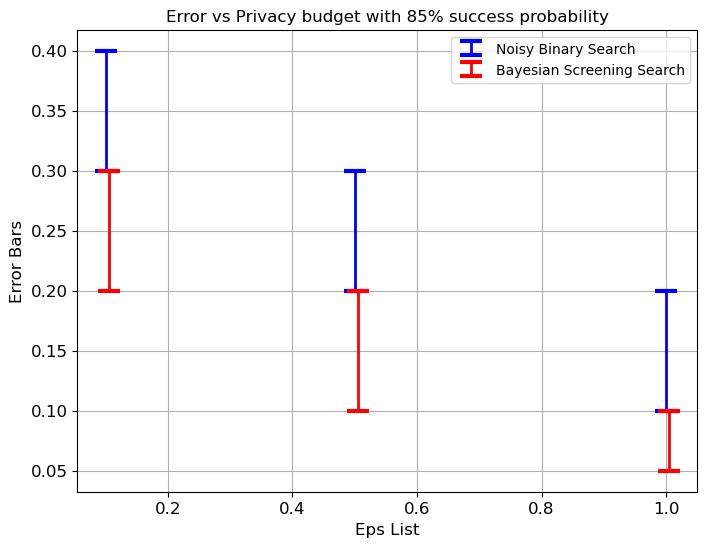

In [234]:
alpha_noisy = [(0.3, 0.4), (0.2, 0.3), (0.1, 0.2)]
alpha_bayes = [(0.2, 0.3), (0.1, 0.2), (0.05, 0.1)]
eps_list = [0.1, 0.5, 1]


def plot(alpha_noisy, alpha_bayes, eps_list):
    eps_list = np.array(eps_list)
    # compute the midle point of the error bars
    mid_noisy = [(noisy[0] + noisy[1]) / 2 for noisy in alpha_noisy]
    mid_bayes = [(bayes[0] + bayes[1]) / 2 for bayes in alpha_bayes]

    # Extract lower and upper error bar values for alpha_noisy and alpha_bayes
    noisy_lower = [mid_noisy[i] - noisy[0] for i, noisy in enumerate(alpha_noisy)]
    noisy_upper = [noisy[1] - mid_noisy[i] for i, noisy in enumerate(alpha_noisy)]

    bayes_lower = [mid_bayes[i] - bayes[0] for i, bayes in enumerate(alpha_bayes)]
    bayes_upper = [bayes[1] - mid_bayes[i] for i, bayes in enumerate(alpha_bayes)]

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.errorbar(eps_list, mid_noisy, yerr=[noisy_lower, noisy_upper], fmt='none', ecolor='blue', elinewidth=2,
                 capsize=8, capthick=3, label='Noisy Binary Search')
    plt.errorbar(eps_list + 0.005, mid_bayes, yerr=[bayes_lower, bayes_upper], fmt='none', ecolor='red', elinewidth=2,
                 capsize=8, capthick=3, label='Bayesian Screening Search')

    plt.xlabel('Eps List', fontsize=12)
    plt.ylabel('Error Bars', fontsize=12)
    plt.title('Error vs Privacy budget with 85% success probability')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()


plot(alpha_noisy, alpha_bayes, eps_list)

In [209]:
mid_noisy

[0.35, 0.25, 0.15000000000000002]